# Electrochemical reduction of carbon dioxide in bicarbonate buffer solutions
Author: Joel W. Ager (jwager@lbl.gov), [Group website](http://ager.mse.berkeley.edu), [github](https://github.com/joelager)

Solves **1D reaction-diffusion** equations for CO<sub>2</sub>-bicarbonate-carbonate-hydroxide systemn using FEM method as implemented in `FEniCS`  
After Gattrell and co-workers  
>Gupta, N.; Gattrell, M.; MacDougall, B. Calculation for the Cathode Surface Concentrations in the Electrochemical Reduction of CO<sub>2</sub> in KHCO<sub>3</sub> Solutions. [J. Appl. Electrochem. **2006**, *36*, 161–172](http://link.springer.com/10.1007/s10800-005-9058-y).

**Overview**
* Look in notebook `CO2 reaction diffusion.ipynb` for steady state 1D solution obtained using `solve_bvp` from `SciPy`  
* Here, the time-dependent 1D solution is obtained using the finite element method as implemented in [FEniCS](https://fenicsproject.org/). There is another notebook that does the 2D solution for different geometries.   
* The problem is a coupled, non-linear system of 4 reaction-diffusion PDEs with Dirichlet boundary condition at the boundary with the bulk electrolyte and Neumann boundary conditions at the electrode surface. 

**Notes on coding the weak form**  

A general reaction-diffusion-advection problem for species $u_i$ would be 

$$\frac{\partial u_1}{\partial t} =  -\vec{w} \cdot \nabla u_1 + \nabla \cdot(D_1 \nabla u_1) +  g_1(u) + f_1(u,t)$$ 

where 

> $u_1$ is concentration of the species, function of position and time  
>$\vec{w} \cdot \nabla u_1$ term is for advection (as in a laminar flow)   
> $\nabla \cdot D_1 \nabla$ term is for diffusion   
> $g_1$ is generation term for $u_1$ as a result of chemical reactions and, in general, depends on the concentration of not only $u_1$ but the other species $u_2$, $u_3$, etc. This term makes the problem non-linear.  
> $f_1$ is a source/sink for $u_1$ acting at the boundaries (as in Neumman boundary conditions) or internally and can be a function of time. 

Moving all terms to LHS and using backwards Euler for the time derivative yields (sort of) the variational form:

$$ \int_{\Omega} \left[ \frac{u^{n+1}-u^n}{\Delta t} v_1 +  D_1 \nabla u_1 \cdot \nabla v_1 + (\vec{w} \cdot \nabla u_1)
v_1-  g_1 v_1  -  f^{n+1} v_1 \right]  dx = 0$$

where the Neumann BC sources are integrated over a surface. Note that written this way, the diffusion term is positive, and the generation terms are negative. And all the second derivatives are gone. In this form, it relatively straightfoward to code the terms for the `dolfin` solver used by `FEniCS`.

# Import packages, units, constants

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from fenics import *

from scipy.interpolate import interp1d
from scipy.optimize import fsolve

from units import *
from CO2parameters import *   

# Optionally overwrite FE values here
## 100% formate. 
#  In this case, pH rise is smaller than for other cases 
#  because only one OH- is made for each CO2 consumed 
FEmethane      = 0.00
FEethylene     = 0.00
FECO           = 0.00
FEformate      = 1.00
FEH2           = 0.00

# Bulk equilibria
$$\require{mhchem}$$
As a first step one needs to solve for the bulk concentrations of bicarbonate and carbonate and for the pH for a given concentation of dissolved CO<sub>2</sub> and carbonate buffer concentration (e.g. KCO<sub>3</sub>, CsCO<sub>3</sub>, etc.)

CO<sub>2</sub>-bicarbonate-carbonate equations for acidic conditions:

$$\ce{CO2{(aq)} +H2O <=> HCO3- + H+}\tag{1a}$$
$$\ce{HCO3- + H2O  <=> CO3^2- + H+}\tag{2a}$$

Equivalently, and suitable for pH > 7, we can write them in the base form:

$$\ce{CO2{(aq)} + OH- <=> HCO3- }\tag{1b}$$
$$\ce{HCO3- + OH-  <=> CO3^2- + H2O}\tag{2b}$$

For this problem there 3 unknowns. The three equations used to solve for them are either the acid or base equilibria above (two equations) plus the charge balance, written here for KHCO<sub>3</sub> buffer. 

$$ [\ce{H+}] + [\ce{K+}] = [\ce{OH-}] + [\ce{HCO3-}] + 2~[\ce{CO3^2-}] $$

Values for the equilibrium constants are in `CO2parameters.py`

**Programming notes**  

The root finder `fsolve` (same name as in Matlab) requires more help to solve the equations compared to *Mathematica*. For example, I was not able to figure out how to constrain the solutions to positive values. And it needs guesses to work properly. Guesses are generated by fitting splines between solutions at a number of buffer concentrations.  
> As a result, at present, the solver will only work for ~33 mm CO<sub>2</sub> (saturation condition for 1 atm) and between 10 and 1000 mM buffer.  

Values for the equilibrium constants and the rate constants are in the file [CO2parameters.py](CO2parameters.py), which is loaded at the begining of the notebook. The FEs for the cathode reactions are specified there as well. Note that one can overwrite the FEs, see above

In [2]:
# For troubleshoooting
# Correct answers for 33 mM and 100 mM buffer from Mathematica solver
# Slightly different values for K1 and K2 used.  
HplusCorrect=    1.4034e-7*molar;
OHminusCorrect = 7.1254e-8*molar;
HCO3correct =    9.9933e-2*molar;
CO3correct =     3.3397e-5*molar;

In [3]:
CO2bulk = 33.4*mM           # Calculated from Henry's law
buffer = 100*mM             # Change this value to get different buffer pH

# Written this way it is the acid equation. 
# So K1a and K2a are used.
# Using the equilibrium constants from the GGM paper. 

def CO2equations(x):
    Hplus, HCO3, CO3 = x
    return (np.log10(Hplus) + np.log10(HCO3) - np.log10(CO2bulk) - np.log10(K1a), \
            np.log10(Hplus)+ np.log10(CO3) - np.log10(HCO3) - np.log10(K2a), \
            Hplus + buffer - Kw/Hplus - HCO3 - 2* CO3 )

# Guesses - these are crucial. Guesses is a python tuple
# This section required more work to handle bulk pH near the pKa of carbonate

pHguess=interp1d([10,50,100,200,300,500,1000,1500],\
                 [5.85,6.55,6.85,7.15, 7.32,7.55, 7.85, 8.02], kind='cubic')
logCO3guess=interp1d([10,50,100,200,300,500,1000,1500],\
                 [-3.48148606, -2.078076083, -1.477555766, -0.876148359, \
                  -0.524328812, -0.080921908, 0.51851394,  3.171726454], kind='cubic')

guesses = (10**(-pHguess(buffer/mM).item(0))*molar,\
           np.abs(buffer-2*10**(logCO3guess(buffer/mM).item(0))*mM), \
           10**(logCO3guess(buffer/mM).item(0))*mM)

# Call the solver
HplusBulk, HCO3bulk, CO3bulk =  fsolve(CO2equations, guesses)
OHbulk = Kw/HplusBulk  

print('Concentrations in the bulk')
print(f'CO2 (mM) = {CO2bulk:3.1f}')               # new way to do formatted print in Python 3.8
print(f'buffer (mM)= {buffer/mM:3.1f}')
print()
print (f'pH = {-np.log10(HplusBulk/molar):3.3f}')
print(f'HCO3(mM) = {HCO3bulk/mM:3.2f}')
print(f'CO3(mM) = {CO3bulk/mM:3.4f}')

Concentrations in the bulk
CO2 (mM) = 33.4
buffer (mM)= 100.0

pH = 6.829
HCO3(mM) = 99.94
CO3(mM) = 0.0314


# System of PDEs
$$\require{mhchem}$$
Consideration of the forward and reverse rates of reactions (1) and (2) above leads to the following equations for CO<sub>2</sub>, HCO<sub>3</sub><sup>-</sup>, CO<sub>3</sub><sup>2-</sup>, and OH<sup>-</sup> in the diffusion layer as a function of time. 

These 4 simultaneous PDEs need to be solved over [0, *L*], where *L* is the thickness of the diffusion layer (typically 100 microns). 

$$ \frac{\partial [\ce{CO2}]}{\partial t} = D_{\ce{CO2}} \frac{d^2 [\ce{CO2}]}{dx^2} - [\ce{CO2}] [\ce{OH-}] k_{1f} + [\ce{HCO3-}]k_{1r}$$

$$ \frac{\partial [\ce{HCO3-}]}{\partial t}  = D_{\ce{HCO3-}} \frac{d^2 [\ce{HCO3-}]}{dx^2}
+ [\ce{CO2}] [\ce{OH-}] k_{1f} - [\ce{HCO3-}]k_{1r}  
- [\ce{HCO3-}] [\ce{OH-}] k_{2f} + [\ce{CO3^2-}] k_{2r}  $$

$$ \frac{\partial [\ce{CO3^2-}]}{\partial t}  = D_{\ce{CO3^2-}} \frac{d^2 [\ce{CO3^2-}]}{dx^2}
+ [\ce{HCO3-}] [\ce{OH-}] k_{2f} - [\ce{CO3^2-}] k_{2r} $$

$$ \frac{\partial [\ce{OH-}]}{\partial t}  = D_{\ce{OH-}} \frac{d^2 [\ce{OH-}]}{dx^2} 
- [\ce{CO2}] [\ce{OH-}] k_{1f} + [\ce{HCO3-}]k_{1r} 
- [\ce{HCO3-}] [\ce{OH-}] k_{2f}+ [\ce{CO3^2-}] k_{2r}$$

Boundary conditions at *L* are the bulk concentrations from the equilibrium solver above. 

Molar flux boundary conditions for CO<sub>2</sub> and OH<sup>-</sup> determined by the current density *j* and the assumed Faradaic efficiencies.  
For 100% FE for CO, they are:

$$ \textrm{molar flux } \ce{CO2} = D_{\ce{CO2}} \frac {d [\ce{CO2}]}{dx} \bigg\lvert _{x=0} =  \left( \frac{j}{F} \right) \frac{1}{2} $$
$$\textrm{molar flux } \ce{OH-}= -D_{\ce{OH-}} \frac {d [\ce{OH-}]}{dx} \bigg\lvert _{x=0} =  \left( \frac{j}{F} \right)  $$

For this example, two electrons are required to make one CO. The reaction consumes two protons, so two hydroxide ions are produced, assuming that water equilibrium is infinitly fast. Flux boundary conditions for bicarbonate and carbonate are zero. The current density *j* is negative for cathodic currents. 

## Geometry and boundary conditions
*L*, the thickness of the diffusion layer, and the current density *j* are set here  
FE values are loaded in [CO2parameter.py](CO2parameters.py). Addition products such as ethanol, acetate, and propanol could be added there.  

In [4]:
L = 100*micron                  # width of diffusion layer. 
jTotal = -5*mA*cm**-2           # Note negative sign for cathodic current

# Flux boundary conditions. 
# In contrast to solve_bvp, do not include the diffusion coefficient. 
# Note dependent on FEs and on z, the number of electrons tranferred to make a given product. 

CO2_molar_flux =  (jTotal/F) * (FEmethane/zMethane    + \
                                FEformate/zFormate    +  \
                                FECO/zCO              +  \
                                2*(FEethylene/zEthylene) )   # 2 for C2 products
                          
g0HCO3  = 0;   # no reaction at electrode for bicarbonate
g0CO3   = 0;   # no reaction at elecrode for carbonate

OH_molar_flux = -(jTotal/F) * ( 8*(FEmethane/zMethane) + \
                                FEformate/zFormate      + \
                                2*(FECO/zCO)            + \
                                12*(FEethylene/zEthylene) + \
                                2*(FEH2/zH2)) ;   # Added - was missing in GGM

print('**********')
print('Bulk CO2 (mM)    = ' + f'{CO2bulk/mM:3.2f}')
print('Buffer (mM)      = ' + f'{buffer/mM:3.2f}')
print('Bulk pH          = ' + f'{-np.log10(HplusBulk/molar):3.3f}')
print()
print('j (mA cm-2)      = ' + f'{jTotal/(mA*cm**-2):3.2f}')
print()
print(''+'\tCH4'+'\tC2H4'+'\tCO'+'\tformate'+ '\tH2')
print('FE\t'+f'{FEmethane:3.2f}'+'\t'+f'{FEethylene:3.2f}'+'\t'+f'{FECO:3.1f}''\t'+f'{FEformate:3.2f}''\t'+f'{FEH2:3.2f}')
print()


print(f'CO2 molar flux is {CO2_molar_flux/(mol*cm**-2):.2e} mol cm^-2 s^-1')        # positive slope
print(f'OH- molar flux is {OH_molar_flux/(mol*cm**-2):.2e} mol cm^-2 s^-1')         # positive slope
print()
print('With no chemistry CO2 at surface would be {:.3f} mM'.format(
                                                    (CO2bulk + L*DCO2**-1*CO2_molar_flux)/mM))
print('With no chemistry OH- at surface would be {:.3e} molar'.format(
                                                    (OHbulk + L*DOH**-1*OH_molar_flux)/molar))
print('    corresponding to pH {:.3f}'.format(
    np.log10((OHbulk + L*DOH**-1*OH_molar_flux)/molar) + 14))

**********
Bulk CO2 (mM)    = 33.40
Buffer (mM)      = 100.00
Bulk pH          = 6.829

j (mA cm-2)      = -5.00

	CH4	C2H4	CO	formate	H2
FE	0.00	0.00	0.0	1.00	0.00

CO2 molar flux is -2.59e-08 mol cm^-2 s^-1
OH- molar flux is 2.59e-08 mol cm^-2 s^-1

With no chemistry CO2 at surface would be 19.834 mM
With no chemistry OH- at surface would be 4.917e-03 molar
    corresponding to pH 11.692


## Setting up the solver
The PDEs and the boundary conditions

In [5]:
# 1D solution is now working
t_final = 20.0                # final time
num_steps = 50                # number of time steps
dt = t_final/num_steps        # time step size, fixed for now

# 1D mesh, evenly spaced
mesh = IntervalMesh(300, 0.0, L)  

# Now make a function space to hold the 4 scalars which are the solution
P1 = FiniteElement('P', interval, 1)
element = MixedElement([P1, P1, P1, P1])
V_hat = FunctionSpace(mesh, element)    # Has subspaces V.sub[0], V.sub[1] etc.

## Set the Dirchlet BCs 
#  Define right boundary.
def right_boundary(x, on_boundary) :
    return on_boundary and near(x[0], L)

# Set values for BCs
bc1 = DirichletBC(V_hat.sub(0), CO2bulk, right_boundary)
bc2 = DirichletBC(V_hat.sub(1), HCO3bulk, right_boundary)
bc3 = DirichletBC(V_hat.sub(2), CO3bulk, right_boundary)
bc4 = DirichletBC(V_hat.sub(3), OHbulk, right_boundary)

BCs = [bc1, bc2, bc3, bc4]

# All BCs on LHS will be Neumann - fixed values or zero  
# There is a note about multiplying by 3 to get actual value of du/dx 
g1_left = CO2_molar_flux    # Is a negative number, acts normal to surface
g2_left = 0.0               # Zero, not used
g3_left = 0.0               # Zero 
g4_left = OH_molar_flux     # Is a positive number

# For the Neumann BCs on the ends
left = AutoSubDomain(lambda x: near(x[0], 0.0))
right = AutoSubDomain(lambda x: near(x[0], L)) 
# Set the boundaries function to return 1 at the left, 2 at the right, 0 otherwise
boundaries = MeshFunction("size_t", mesh, mesh.topology().dim() - 1, 0)
boundaries.set_all(0)

# These will be used in the weak form 
left.mark(boundaries, 1)
right.mark(boundaries, 2)
# Important - need this statement
ds = ds(subdomain_data=boundaries) 

#  Set the trial and test functions.
u = Function(V_hat)                # Function not TrialFunction for non-linear problems
u_new = Function(V_hat)            # scalar, for the next time step
cCO2, cHCO3, cCO3, cOH = split(u)
cCO2_new, cHCO3_new, cCO3_new, cOH_new = split(u_new)
v1, v2, v3, v4 = TestFunction(V_hat)

# Initial conditions
u_init = Expression(('CO2bulk','HCO3bulk','CO3bulk','OHbulk'), degree=1,
                   CO2bulk=CO2bulk, HCO3bulk=HCO3bulk, CO3bulk=CO3bulk, OHbulk=OHbulk)
u.interpolate(u_init)
u_new.interpolate(u_init)          # Added this

# Define variational problem, use indents to isolate the chemistry
#  First line is time and advection (not used here)
#  Second line is diffusion
#  Third line is chemistry - written as a negative term
#                           inside parens sinks are negative, sources are positive
#  Fourth line is spatial source terms (not used here) and Neumann BCs
R1 = ((cCO2 - cCO2_new)/dt)*v1*dx   \
     + DCO2*dot(grad(cCO2), grad(v1))*dx \
     - (-k1f*cCO2*cOH + k1r*cHCO3)*v1*dx \
     - g1_left*v1*ds(1)
     
R2 = ((cHCO3 - cHCO3_new)/dt)*v2*dx   \
     + DHCO3*dot(grad(cHCO3), grad(v2))*dx \
     - (+k1f*cCO2*cOH - k1r*cHCO3 - k2f*cHCO3*cOH + k2r*cCO3)*v2*dx # \
    # - g2_left*v2*ds(1)

R3 = ((cCO3 - cCO3_new)/dt)*v3*dx   \
     + DCO3*dot(grad(cCO3), grad(v3))*dx \
     - (+k2f*cHCO3*cOH - k2r*cCO3)*v3*dx # \
    # - g3_left*v3*ds(1)

R4 = ((cOH - cOH_new)/dt)*v4*dx   \
     + DOH*dot(grad(cOH), grad(v4))*dx \
     - (-k1f*cCO2*cOH + k1r*cHCO3 - k2f*cHCO3*cOH + k2r*cCO3)*v4*dx \
     - g4_left*v4*ds(1)
     
Eqs = R1 + R2 + R3 + R4   # Add them together for the coupled problem

# np.array to store the solution
u_sol = u.compute_vertex_values()          # first entry will be initial condition

# Interate to compute solution
t = 0
num_steps = int(t_final/dt)
for n in range(num_steps):
    # Update current time
    t += dt                    # Update time
    solve(Eqs == 0, u, BCs, 
          solver_parameters={"newton_solver":           # Sent instructions to the Newton solver
                        {"relative_tolerance": 1e-9}})  # Default toleracne is 1e-9
    u_new.assign(u)                                      # Update for next step and append vertex values to np.array
    u_sol = np.vstack((u_sol,u_new.compute_vertex_values()))

# split the solution
# Time in in rows, position of solution is in columns
CO2_sol, HCO3_sol, CO3_sol, OH_sol = np.hsplit(u_sol, 4)
pH_sol = 14.0 + np.log10(OH_sol/molar)

In [6]:
# Crude selection of points in solution to plot
i_sample = []

i=0
while i < num_steps:
    if i*dt < 2.4:
        i_sample.append(i)
    elif i*dt < 5.4:
         if i%4 == 0:
            i_sample.append(i)
    else:
        if i%8 == 0:
            i_sample.append(i)
    i += 1  
i_sample

#for i in i_sample:
#    print(i)

[0, 1, 2, 3, 4, 5, 8, 12, 16, 24, 32, 40, 48]

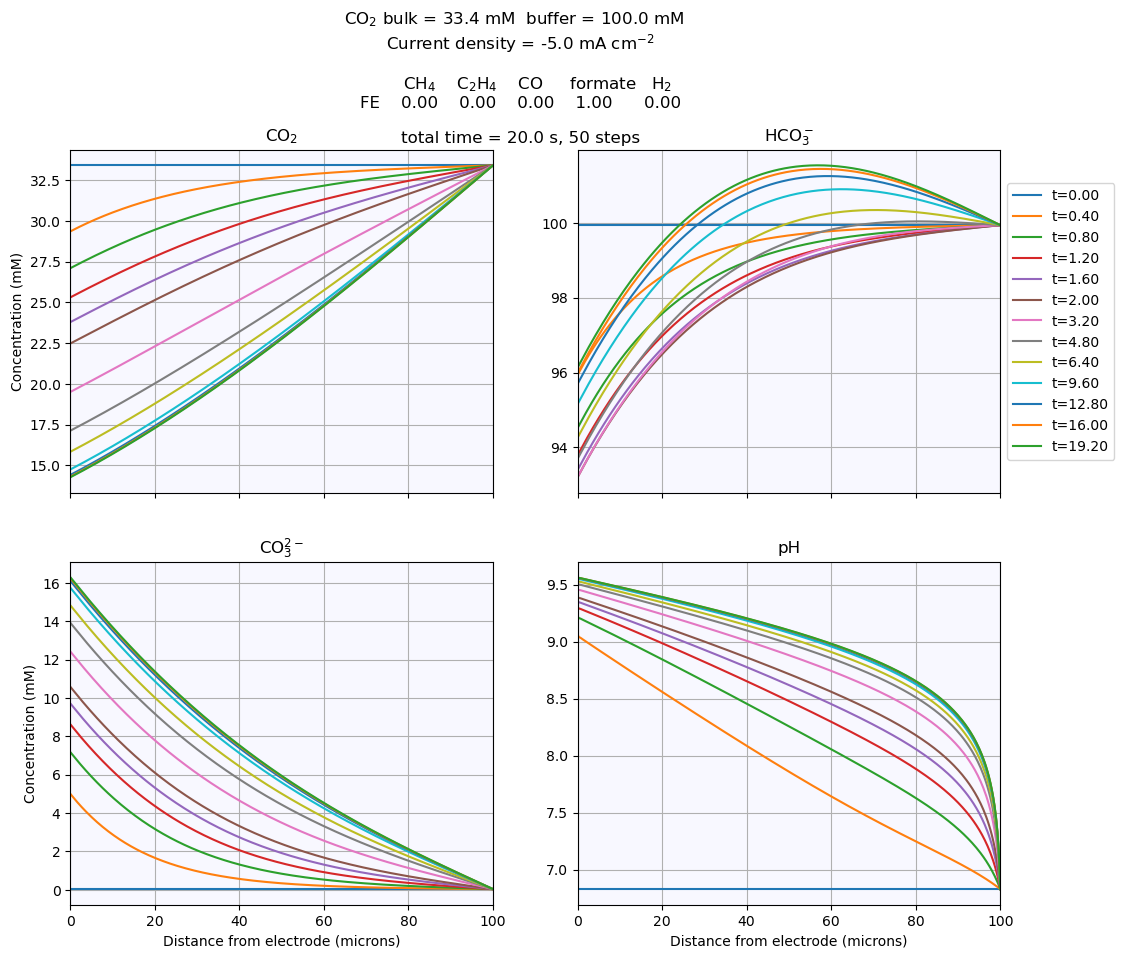

**********
Bulk CO2 (mM)    = 33.40
Buffer (mM)      = 100.00
Bulk pH          = 6.829

j (mA cm-2)      = -5.00

	CH4	C2H4	CO	formate	H2
FE	0.00	0.00	0.0	1.00	0.00

After 20.00 seconds
surface CO2 (mM) = 14.26
surface CO2 (mM) = 9.57


In [7]:
# Visualize
x_grid = mesh.coordinates()

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2, figsize=(12,10), dpi=100, sharex=True, sharey=False) 
fig.suptitle(f'CO$_2$ bulk = {CO2bulk/mM:3.1f} mM  buffer = {buffer/mM:3.1f} mM   '
             f'\nCurrent density = {jTotal/(mA*cm**-2):3.1f} mA cm$^{{-2}}$\n\n'
            '       CH$_4$    C$_2$H$_4$    CO     formate   H$_2$ \n' 
            f'FE    {FEmethane:3.2f}    {FEethylene:3.2f}    {FECO:3.2f}    {FEformate:3.2f}      {FEH2:3.2f}\n'
             f'\ntotal time = {t_final} s, {num_steps} steps',
            fontsize=12, y=1.02)
ax1.set_title('CO$_2$'); ax2.set_title('HCO$_3^-$'); ax3.set_title('CO$_3^{2-}$'); ax4.set_title('pH')

for i in i_sample:      # plot every nth solution
    
    ax1.plot(x_grid/micron, CO2_sol[i,:]/mM, label='t={0:1.2f}'.format(i*dt))   # note nice formatting. 
    ax2.plot(x_grid/micron, HCO3_sol[i,:], label='t={0:1.2f}'.format(i*dt))   # note nice formatting. 
    ax3.plot(x_grid/micron, CO3_sol[i,:], label='t={0:1.2f}'.format(i*dt))   # note nice formatting. 
    ax4.plot(x_grid/micron, pH_sol[i,:], label='t={0:1.2f}'.format(i*dt))   # note nice formatting. 
  
ax1.set_xlim(0,100)
ax3.set_xlabel('Distance from electrode (microns)')
ax4.set_xlabel('Distance from electrode (microns)')
ax1.set_ylabel('Concentration (mM)')
ax3.set_ylabel('Concentration (mM)')
ax1.grid(); ax2.grid(); ax3.grid(); ax4.grid(); 
# adjust figure edges so the legend is in the figure
ax2.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=10)

#plt.subplots_adjust(top=0.89, right=0.77)
ax1.set_facecolor('ghostwhite'); ax2.set_facecolor('ghostwhite')
ax3.set_facecolor('ghostwhite'); ax4.set_facecolor('ghostwhite')

plt.show() 

print('**********')
print('Bulk CO2 (mM)    = ' + f'{CO2bulk/mM:3.2f}')
print('Buffer (mM)      = ' + f'{buffer/mM:3.2f}')
print('Bulk pH          = ' + f'{-np.log10(HplusBulk/molar):3.3f}')
print()
print('j (mA cm-2)      = ' + f'{jTotal/(mA*cm**-2):3.2f}')
print()
print(''+'\tCH4'+'\tC2H4'+'\tCO'+'\tformate'+ '\tH2')
print('FE\t'+f'{FEmethane:3.2f}'+'\t'+f'{FEethylene:3.2f}'+'\t'+f'{FECO:3.1f}''\t'+f'{FEformate:3.2f}''\t'+f'{FEH2:3.2f}')
print()
print(f'After {t_final:.2f} seconds')
print('surface CO2 (mM) = ' + f'{np.split(u_sol[-1,:], 4)[0][0]/mM:3.2f}')
print('surface CO2 (mM) = ' + f'{14.0 + np.log10(np.split(u_sol[-1,:], 4)[3][0]/molar):3.2f}')



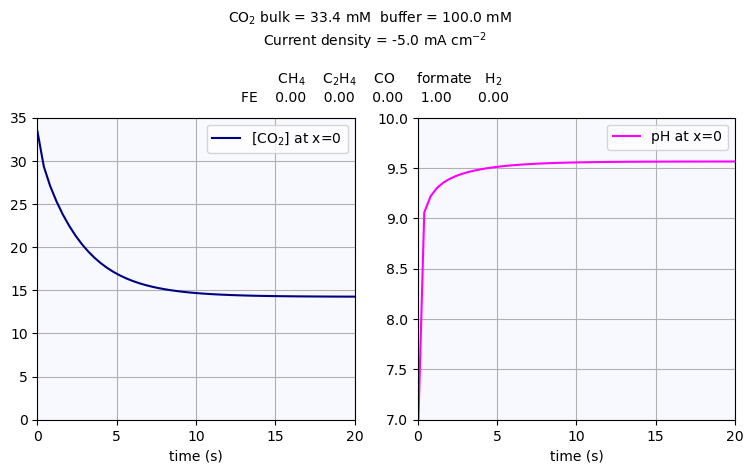

In [8]:
# CO2 and pH as a function of time
t_array = [i*dt for i in np.arange(num_steps + 1)]

# Visualize
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(9,4), dpi=100, sharex=True, sharey=False) 
fig.suptitle(f'CO$_2$ bulk = {CO2bulk/mM:3.1f} mM  buffer = {buffer/mM:3.1f} mM   '
             f'\nCurrent density = {jTotal/(mA*cm**-2):3.1f} mA cm$^{{-2}}$\n\n'
            '       CH$_4$    C$_2$H$_4$    CO     formate   H$_2$ \n' 
            f'FE    {FEmethane:3.2f}    {FEethylene:3.2f}    {FECO:3.2f}    {FEformate:3.2f}      {FEH2:3.2f}\n',
            fontsize=10, y=1.15)
#ax1.set_title('CO$_2$')
#ax2.set_title('pH')
    
ax1.plot(t_array, CO2_sol[:,0]/mM, 'navy' , label='[CO$_2$] at x=0')   # note nice formatting. 
ax2.plot(t_array, pH_sol[:,0], 'magenta', label = 'pH at x=0')   # note nice formatting. 
    
ax1.set_xlabel('time (s)')
ax2.set_xlabel('time (s)')
ax1.set_ylim(0,35)
ax1.set_xlim(0,20)

ax2.set_ylim(7,10)


ax1.grid(); ax2.grid()
ax1.legend(loc='upper right')
ax2.legend(loc='upper right')

ax1.set_facecolor('ghostwhite')
ax2.set_facecolor('ghostwhite')

plt.show() 

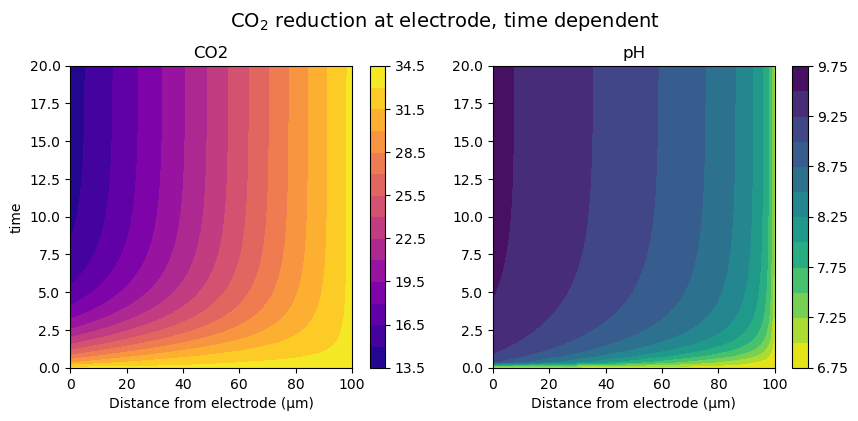

In [9]:
# Fancy color plot

# To make a 2D surface plot need X, Y, Z. Each is a 2D arrary with the X, Y, and Z values for each data point. 
X, Y = np.meshgrid(mesh.coordinates(), t_array)
#print(X.shape, Y.shape)
#print()
#print(np.hsplit(u_sol, 2)[0].shape)

fig, (ax1,ax2) = plt.subplots(1,2, figsize=(10,4), dpi=100)
fig.suptitle('CO$_2$ reduction at electrode, time dependent\n', y=1.02, fontsize=14)
ax1.set_title('CO2')
c1 = ax1.contourf(X/micron, Y, CO2_sol, 12,  cmap='plasma')
plt.colorbar(c1, ax=ax1)
ax1.set_xlabel('Distance from electrode (μm)')
ax1.set_ylabel('time')

ax2.set_title('pH')
c2 = ax2.contourf(X/micron, Y, pH_sol, 12,  cmap='viridis_r')

plt.colorbar(c2, ax=ax2)
ax2.set_xlabel('Distance from electrode (μm)')

plt.show()